# <span style='color:rgb(102, 51, 0)'> Projet d'économétrie SIM215 </span>

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import f

# <span style='color:rgb(102, 51, 0)'> Partie 2. Séries Temporelles  </span>

## <span style='color:rgb(102, 51, 0)'> 1. Importer les données du fichier quarterly.xls (corriger le problème éventuel d’observations manquantes)  </span>

In [53]:
data_file = 'quarterly.xls'
data = pd.read_excel(data_file, header=0, index_col=False, keep_default_na=True)
data1 = data.reset_index()
data1

,index,DATE,FFR,Tbill,Tb1yr,r5,r10,PPINSA,Finished,CPI,CPICORE,M1NSA,M2SA,M2NSA,Unemp,IndProd,RGDP,Potent,Deflator,Curr
0,0,1960Q1,3.93,3.87,4.57,4.64,4.49,31.67,33.20,29.40,18.92,140.53,896.1,299.40,5.13,23.93,2845.3,2824.2,18.521,31.830
1,1,1960Q2,3.70,2.99,3.87,4.30,4.26,31.73,33.40,29.57,19.00,138.40,903.3,300.03,5.23,23.41,2832.0,2851.2,18.579,31.862
2,2,1960Q3,2.94,2.36,3.07,3.67,3.83,31.63,33.43,29.59,19.07,139.60,919.4,305.50,5.53,23.02,2836.6,2878.7,18.648,32.217
3,3,1960Q4,2.30,2.31,2.99,3.75,3.89,31.70,33.67,29.78,19.14,142.67,932.8,312.30,6.27,22.47,2800.2,2906.7,18.700,32.624
4,4,1961Q1,2.00,2.35,2.87,3.64,3.79,31.80,33.63,29.84,19.17,142.23,948.9,317.10,6.80,22.13,2816.9,2934.8,18.743,32.073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,207,2011Q4,0.07,0.01,0.11,0.95,2.05,200.77,192.97,226.97,112.50,2165.77,28787.3,9599.47,8.67,95.33,13441.0,14255.9,113.987,1055.496
208,208,2012Q1,0.10,0.07,0.16,0.90,2.04,202.17,193.73,228.27,113.12,2213.97,29238.6,9777.03,8.27,96.70,13506.4,14317.4,114.599,1082.519
209,209,2012Q2,0.15,0.09,0.19,0.79,1.82,201.80,192.83,228.84,113.60,2258.30,29611.6,9888.97,8.17,97.27,13548.5,14379.3,115.035,1104.500
210,210,2012Q3,0.14,0.10,0.18,0.67,1.64,202.40,195.20,230.03,113.91,2326.47,30251.4,10029.87,8.03,97.39,13652.5,14441.9,115.810,1119.187


## <span style='color:rgb(102, 51, 0)'> 2. Stationnariser la série de CPI en utilisant la méthode de régression qui inclut un terme de tendance dont la forme fonctionnelle est à choisir (linéaire, quadratique, log, exponentielle,...) </span>

### Observation de la série

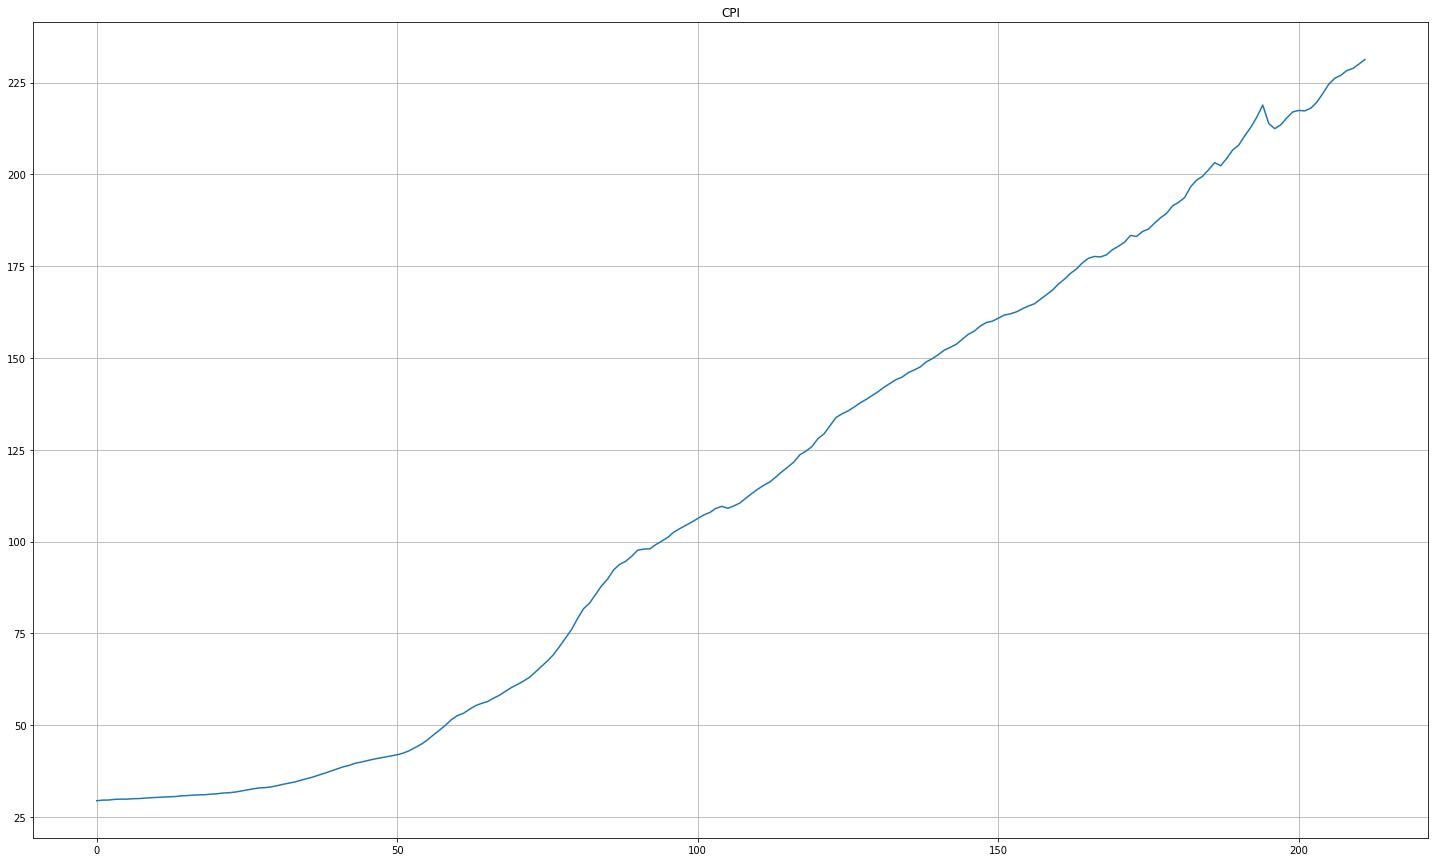

In [54]:
plt.figure(figsize=(25, 15))
plt.plot(data1.CPI)
plt.grid(True)
plt.title("CPI");

## Regression: CPI = constante + trend + erreur (forme linéaire)

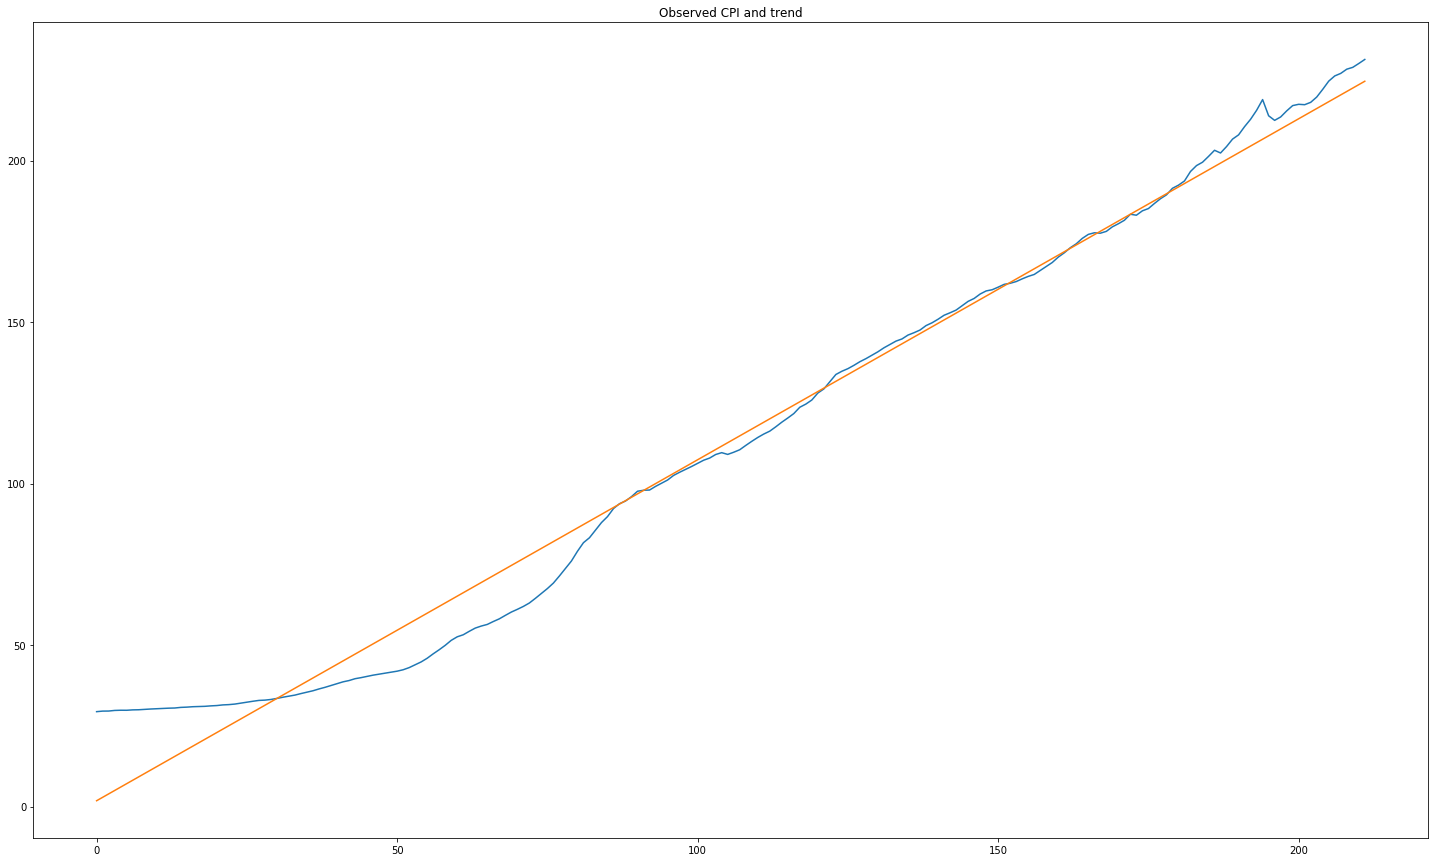

In [55]:
X = [i for i in range(0, len(data1))]
X = np.reshape(X, (len(X), 1))
Y = data1.CPI.values

model = LinearRegression()
model.fit(X, Y)
trend = model.predict(X)

plt.figure(figsize=(25, 15))
plt.plot(Y)
plt.plot(trend)
plt.title("Observed CPI and trend")
plt.show();

## Removing trend (Detrend)

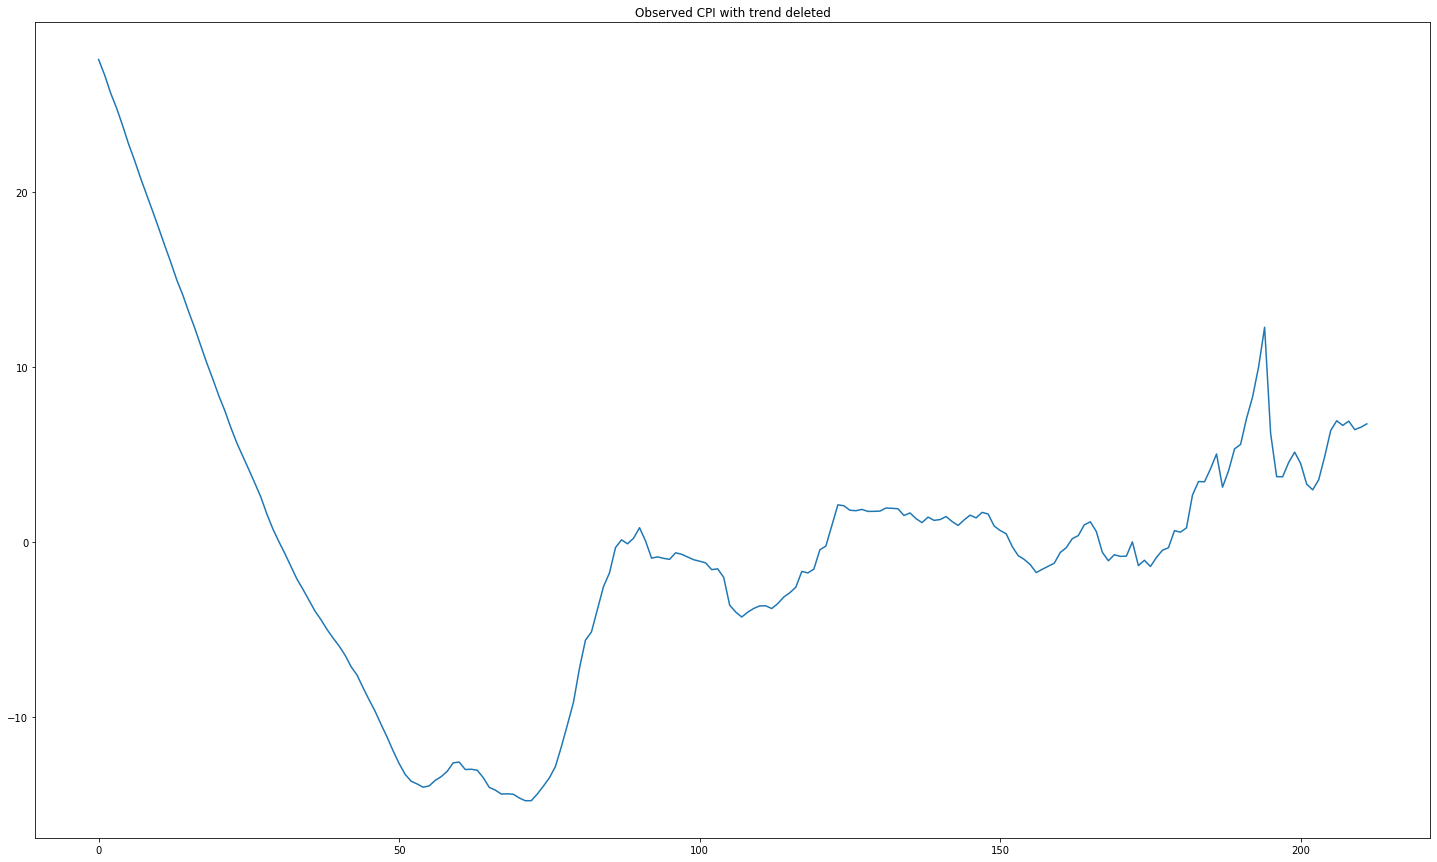

In [56]:
detrend = [Y[i]-trend[i] for i in range(0, len(data1))]
plt.figure(figsize=(25, 15))
plt.plot(detrend)
plt.title("Observed CPI with trend deleted")
plt.show()

## <span style='color:rgb(102, 51, 0)'> 3. Stationnariser la série de CPI en utilisant une moyenne mobile centrée 5x5 </span>

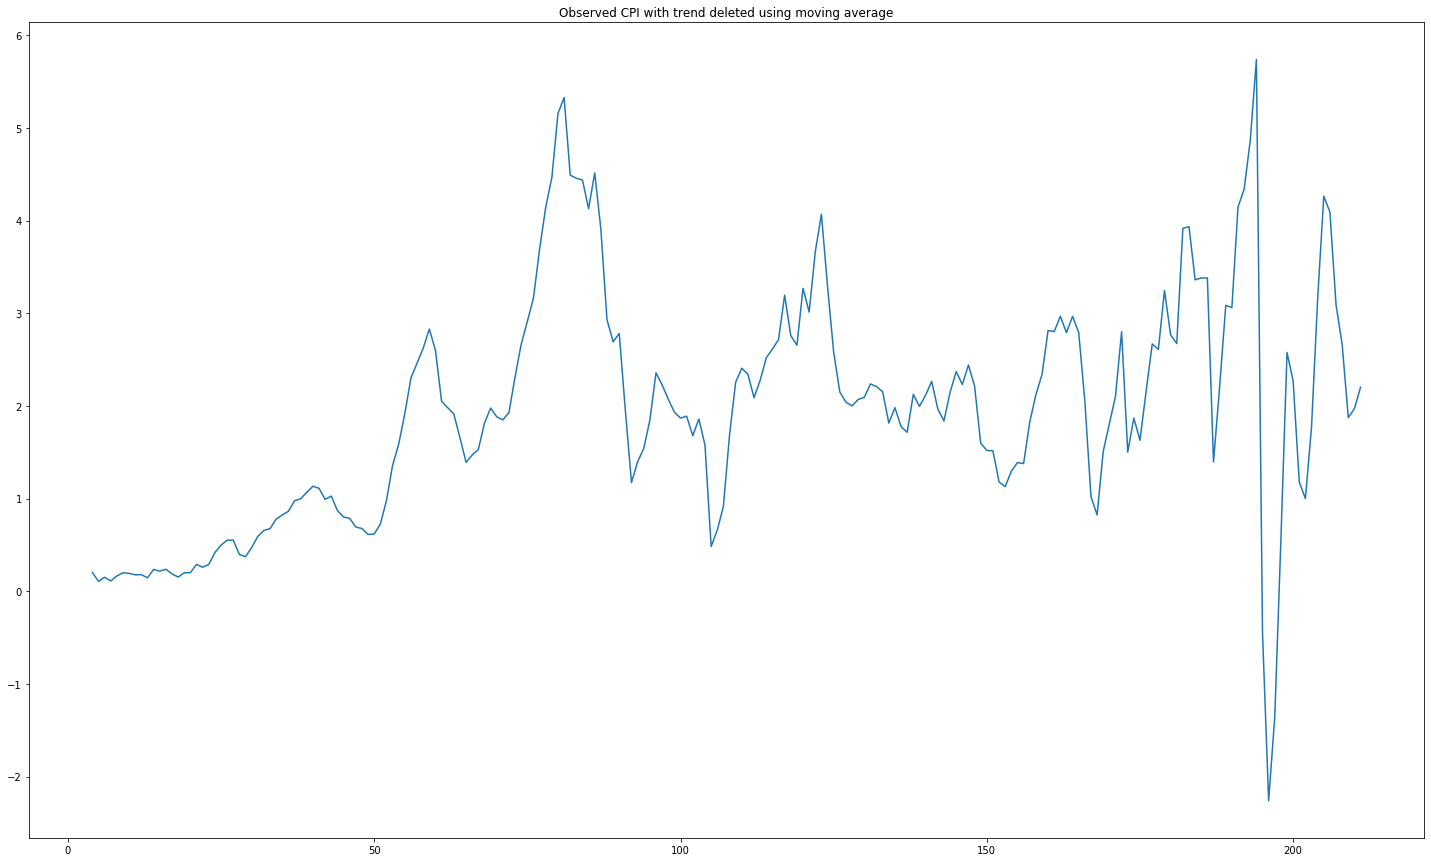

In [57]:
t = data1.CPI.rolling(window=5).mean()
stationary = data1.CPI - t

plt.figure(figsize=(25, 15))
plt.plot(stationary)
plt.title("Observed CPI with trend deleted using moving average")
plt.show()

## <span style='color:rgb(102, 51, 0)'> 4. Calculer inf, le taux d’inflation à partir de la variable CPI. Faire un graphique dans le temps de inf. Commentez </span>

$\Large INF = \frac{CPI_{t} - CPI_{t-1}}{CPI_{t-1}} $ 

### Calcul de INF

In [58]:
data1['CPI_lag'] = data1.CPI.shift(periods=1, fill_value=0)
data1['CPI_lag'].loc[0] = 1.0
data1['diff_CPI'] = data1.CPI - data1['CPI_lag']
data1['diff_CPI'].loc[0] = 0.0

data1['INF'] = (data1.diff_CPI/data1.CPI_lag)*100
data1['CPI_lag'].loc[0] = 0.0
data1

/home/ongono/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,index,DATE,FFR,Tbill,Tb1yr,r5,r10,PPINSA,Finished,CPI,...,M2NSA,Unemp,IndProd,RGDP,Potent,Deflator,Curr,CPI_lag,diff_CPI,INF
0,0,1960Q1,3.93,3.87,4.57,4.64,4.49,31.67,33.20,29.40,...,299.40,5.13,23.93,2845.3,2824.2,18.521,31.830,0.00,0.00,0.000000
1,1,1960Q2,3.70,2.99,3.87,4.30,4.26,31.73,33.40,29.57,...,300.03,5.23,23.41,2832.0,2851.2,18.579,31.862,29.40,0.17,0.578231
2,2,1960Q3,2.94,2.36,3.07,3.67,3.83,31.63,33.43,29.59,...,305.50,5.53,23.02,2836.6,2878.7,18.648,32.217,29.57,0.02,0.067636
3,3,1960Q4,2.30,2.31,2.99,3.75,3.89,31.70,33.67,29.78,...,312.30,6.27,22.47,2800.2,2906.7,18.700,32.624,29.59,0.19,0.642109
4,4,1961Q1,2.00,2.35,2.87,3.64,3.79,31.80,33.63,29.84,...,317.10,6.80,22.13,2816.9,2934.8,18.743,32.073,29.78,0.06,0.201478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,207,2011Q4,0.07,0.01,0.11,0.95,2.05,200.77,192.97,226.97,...,9599.47,8.67,95.33,13441.0,14255.9,113.987,1055.496,226.18,0.79,0.349279
208,208,2012Q1,0.10,0.07,0.16,0.90,2.04,202.17,193.73,228.27,...,9777.03,8.27,96.70,13506.4,14317.4,114.599,1082.519,226.97,1.30,0.572763
209,209,2012Q2,0.15,0.09,0.19,0.79,1.82,201.80,192.83,228.84,...,9888.97,8.17,97.27,13548.5,14379.3,115.035,1104.500,228.27,0.57,0.249704
210,210,2012Q3,0.14,0.10,0.18,0.67,1.64,202.40,195.20,230.03,...,10029.87,8.03,97.39,13652.5,14441.9,115.810,1119.187,228.84,1.19,0.520014


### Graphique de l'inflation au cours du temps

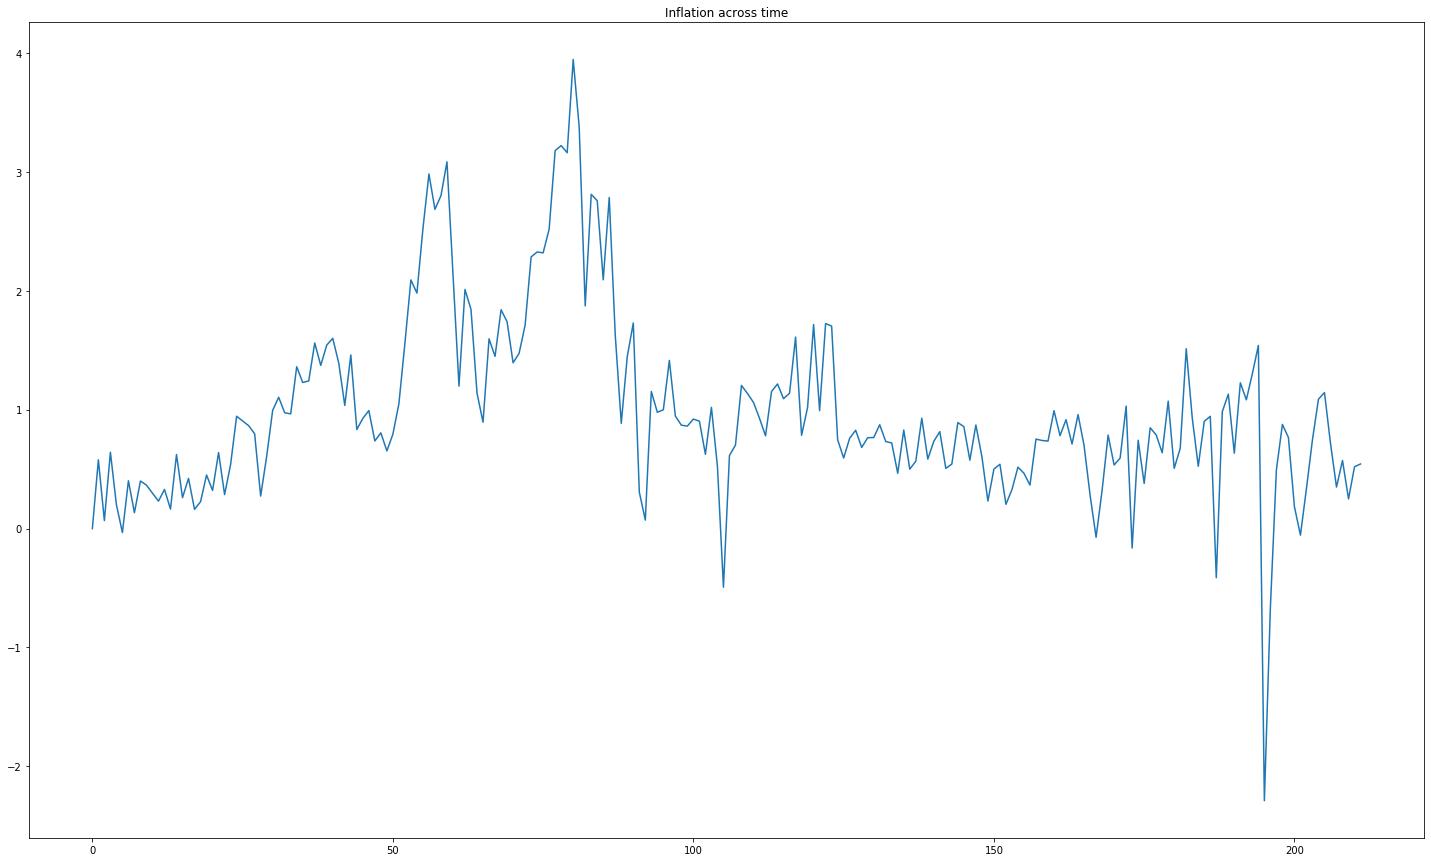

In [59]:
plt.figure(figsize=(25, 15))
plt.plot(data1['INF'])
plt.title("Inflation across time")
plt.show()

### Commentaire

Nous constatons que nous avons des périodes ponctuelles d'inflation ou de déflation importantes. Par ailleurs, le processus ne semble pas être stationnaire avec des fluctuations importantes. Aussi, il est difficile d'identifier des effets de cycle dans le processus. 




## <span style='color:rgb(102, 51, 0)'> 5. Interpréter l'autocorrélogramme et l'autocorrélogramme partiel de inf. Quelle est la différence entre ces deux graphiques ?</span>

## Autocorrélogramme

/home/ongono/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


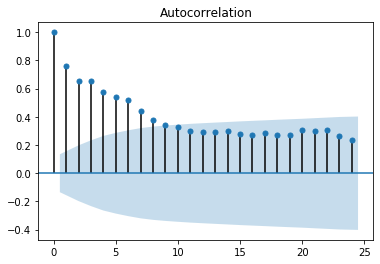

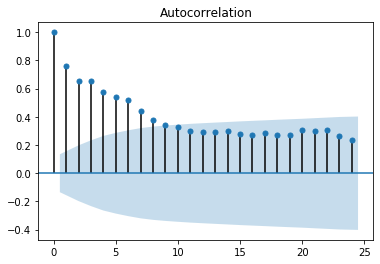

In [60]:
acf(data1['INF'])
plot_acf(data1['INF'])

### Interprétation de l'autocorrelogramme

L'autocorrelation mesure le dégré de liaison lineaire entre une observation et son passé d'ordre k. Plus l'autocorrélation tend vers la valeur 1, plus la liaison linéaire est forte entre les observations présentes et les observations passées d'ordre k. Dans le corrélogramme ci-dessus, on voit que la corrélation linéaire d'ordre 1 entre les observations présentes et passées diminue au file du temps.

## Autocorrélogramme partiel

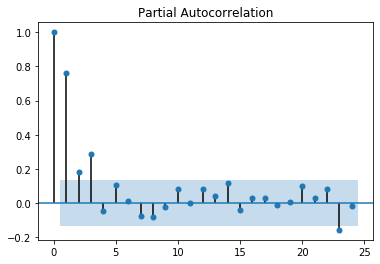

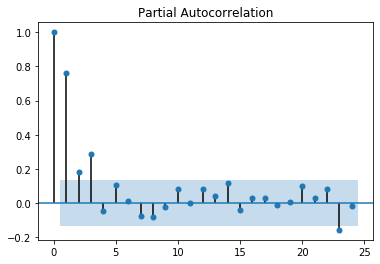

In [61]:
pacf(data1['INF'])
plot_pacf(data1['INF'])

### Interprétation de l'autocorrélogramme partiel

L'autocorrélogramme partiel mesure la corrélation linéaire entre les résidus de deux variables présente et passée d'un phénomene pour lesquelles on a extrait les effets à l'ordre k des autres variables passées. Formellement on a:

$\Large X_{t} = \alpha_{1}X_{t-1} + \alpha_{2}X_{t-2} + ... + \alpha_{h-1}X_{t-h+1} + u$

$\Large X_{t-h} = \alpha_{1}X_{t-1} + \alpha_{2}X_{t-2} + ... + \alpha_{h-1}X_{t-h+1} + v$

$\Large \gamma(h) = Corr(U,V)$ $\quad \quad$ avec $\Large \gamma(h) $ = l'autocorrélation partielle


### Différence entre l'autocorrelogramme et l'autocorrélogramme partiels


## <span style='color:rgb(102, 51, 0)'> 6. Quelle est la différence entre la stationnarité et l'ergodicité ? Pourquoi a-t-on besoin de ces deux conditions. Expliquez le terme "spurious regression" </span>

### Stationnarité
Un processus est stationnaire lorsqu'il respecte les trois propriétés suivantes:

$\Large E(X_{t}) = \mu $

$\Large E(X_{t}²) < \infty $ 

$\Large COV(X_{t}, X_{t-k}) = \gamma(k)$ ne dépend pas du temps


### Ergodicité
Un processus est ergodique si l’on peut calculer l’ensemble de ses caractéristiques (moyenne, variance, fonction d’autocorrélation) à partir d’une seule trajectoire du processus c'est à dire de la série temporelle observée sur une longue période. L'ergodicité assure que les moyennes temporelles sont identiques aux moyennes statistiques, ce qui permet de connaître entièrement la statistique à partir d'une seule réalisation. Formellement on a:


$\Large COV(X_{t}, X_{t-k}) = \gamma(k) \quad \longrightarrow 0 \quad \quad si \quad \quad k \longrightarrow \infty $


### "Spurious regression"
La régression fallacieuse désigne une situation dans laquelle une régression linéaire fait apparaître des résultats intéressants avec de bonnes propriétés faisant croire à une relation forte entre les variables alors que ce n'est pas le cas. Ceci peut arriver lorsque la série n'est pas stationnaire et que l'on estime une quelconque relation sans stationariser les séries.

## <span style='color:rgb(102, 51, 0)'> 7. Faire le test Augmented Dickey Fuller pour inf en utilisant le critère AIC pour déterminer le nombre de lags à inclure. Commenter </span>

In [62]:
dftest = adfuller(data1.INF, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
dfoutput

Test Statistic                  -3.012203
p-value                          0.033770
Lags Used                        2.000000
Number of Observations Used    209.000000
dtype: float64

### Commentaire:

La série est stationnaire si on applique 2 lag tel que le montre les statistiques qui accompagnent le test. En prenant ces deux lag la serie est stationnaire à un seuil de 5% de risque de se tromper.

## <span style='color:rgb(102, 51, 0)'> 8. Proposer une modélisation AR(p) de inf, en utilisant tous les outils vus au cours. </span>


### Précédement, le test de dicker-fuller augmenté montre que le nombre de lag à inclure est de 2. Nous allons faire une boucle sur l'estimation AR(k) pour déterminer quel est le k qui procure le AIC le plus bas.

In [63]:
aic_list = []
bic_list = []
for k in range(1, 11):
    model = smt.AR(data1.INF).fit(maxlag=k)
    aic_list.append(model.aic)
    bic_list.append(model.bic)

/home/ongono/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarn

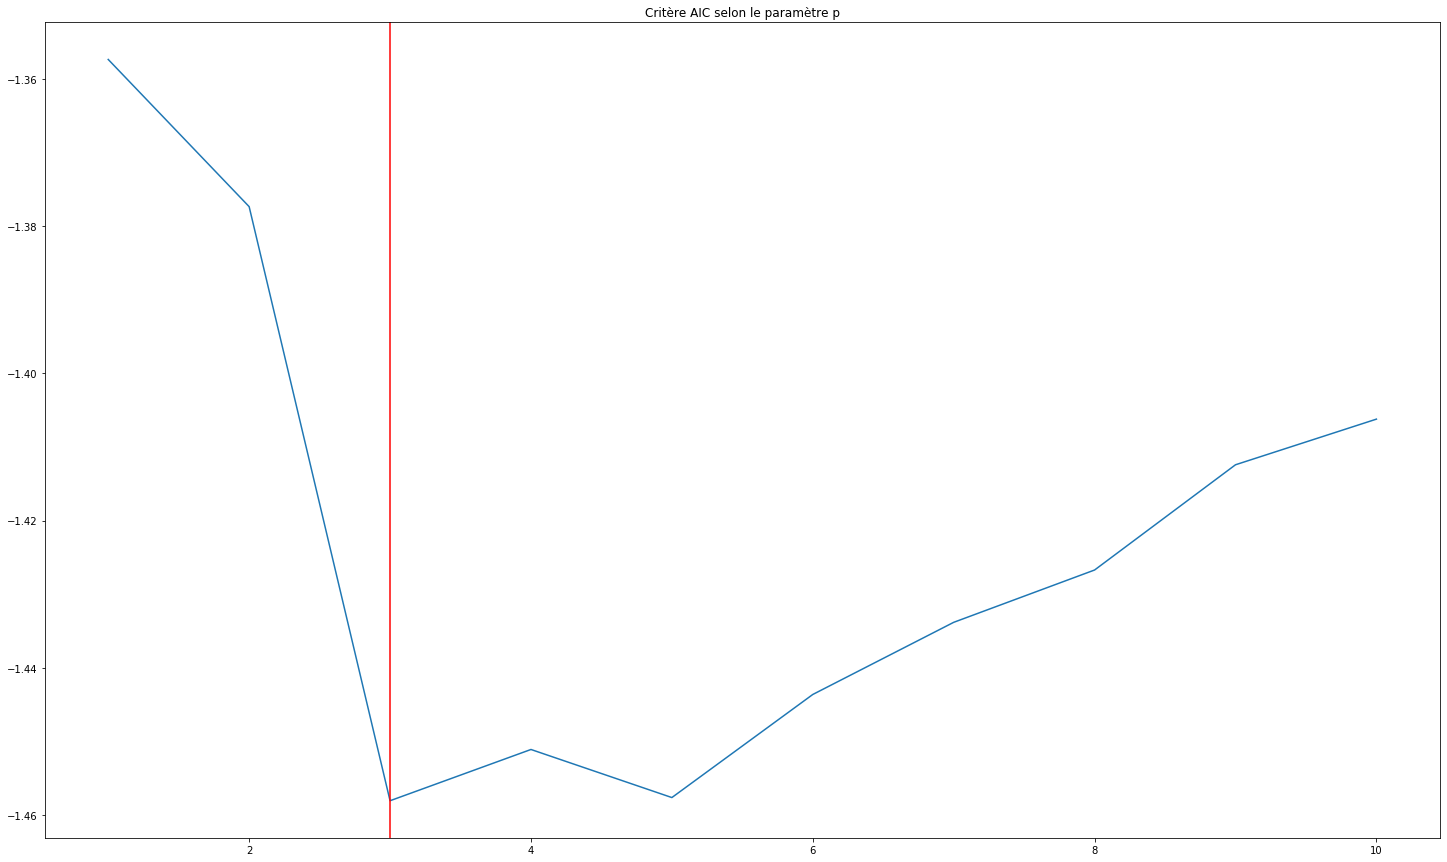

In [64]:
plt.figure(figsize=(25, 15))
plt.plot(range(1, 11), aic_list)
plt.axvline(3, c='red')
plt.title("Critère AIC selon le paramètre p")
plt.show()

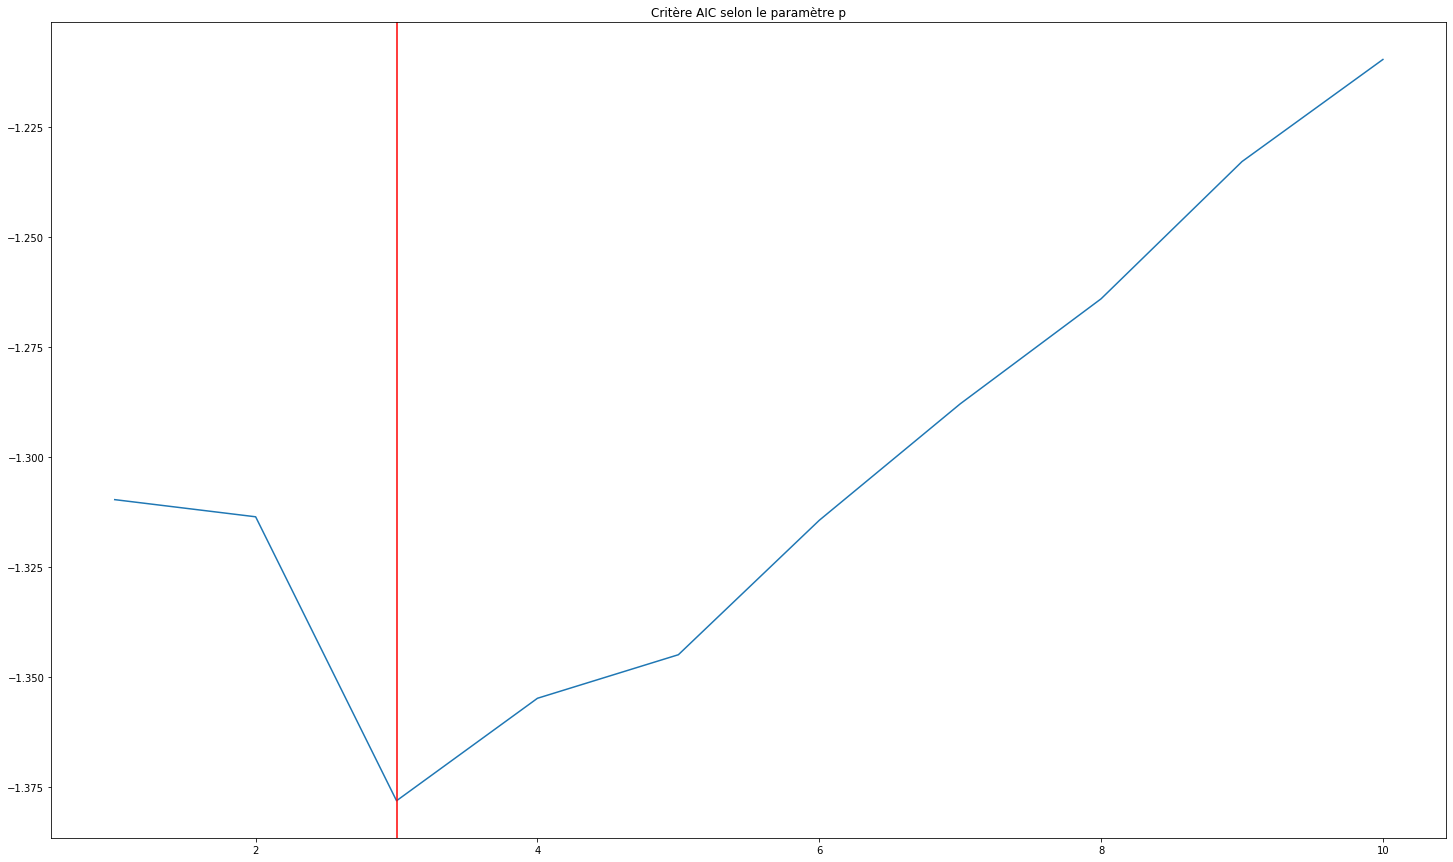

In [65]:
plt.figure(figsize=(25, 15))
plt.plot(range(1, 11), bic_list)
plt.axvline(3, c='red')
plt.title("Critère AIC selon le paramètre p")
plt.show()

Le retard p = 3 est celui qui minimise au mieux le critère AIC et BIC. Nous retiendrons alors p = 3 pour le modèle AR, soit AR(3).

### Estimation d'un modèle AR(3) et présentation de la prédiction

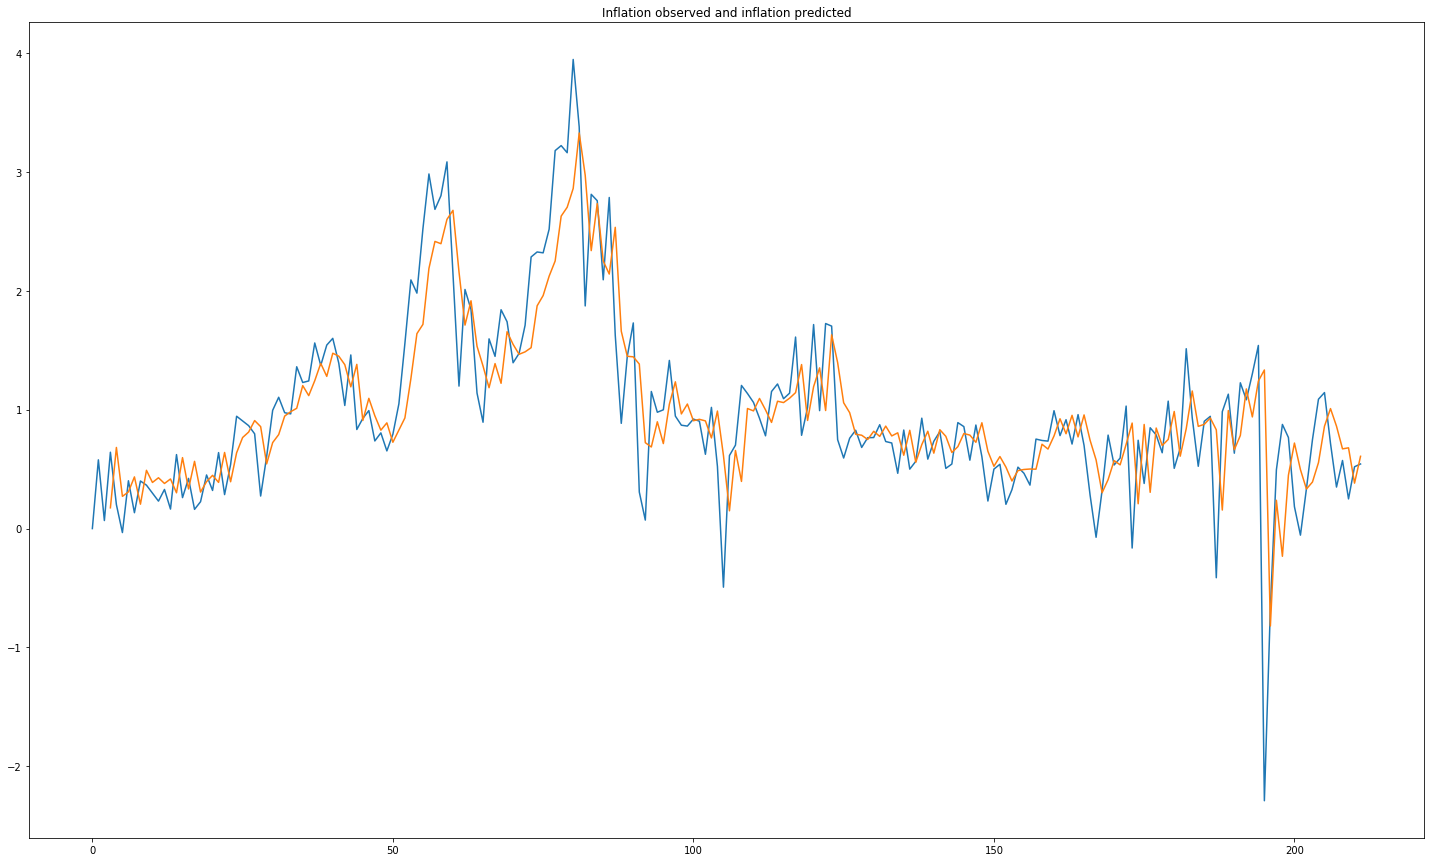

In [66]:
model = smt.AR(data1.INF).fit(maxlag=3)
output = model.predict()

plt.figure(figsize=(25, 15))
plt.plot(data1['INF'], label="observed")
plt.plot(output, label="predicted")
plt.title("Inflation observed and inflation predicted")
plt.show()

### Commentaire:
L'estimation d'un AR(3) montre qu'il y a une certaine précision à la prévision et que l'erreur de prévision apparaît pas très forte.

## <span style='color:rgb(102, 51, 0)'>  9. Estimer le modèle de la courbe de Philips qui explique le taux de chômage (Unemp) en fonction du taux d’inflation courant et une constante </span>

In [67]:
model = sm.OLS(data1.Unemp, sm.add_constant(data1.INF))
results = model.fit()
print(results.summary())

data1['residus'] = results.resid

                            OLS Regression Results                            
Dep. Variable:                  Unemp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.02604
Date:                Sun, 12 Apr 2020   Prob (F-statistic):              0.872
Time:                        13:06:28   Log-Likelihood:                -401.84
No. Observations:                 212   AIC:                             807.7
Df Residuals:                     210   BIC:                             814.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0593      0.179     33.774      0.0

/home/ongono/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Commentaire

Cette simple regression montre que l'inflation n'est pas significative. On peut donc être amené à conclure que celle-ci n'explique pas le niveau de chômage.

## <span style='color:rgb(102, 51, 0)'> 10. Tester l’autocorrélation des erreurs </span>

Le test de Durbin-Watson est un test qui permet de détecter s'il y a une autocorrélation entre les erreurs d'une regression linéaire. La valeur de la statistique de Durbin et Watson est encadrée par les valeurs de 0 et 4. Lorsque la valeur de cette statistique tend vers 0 on parle d'autocorrelation des erreurs positive. Mais si elle tend vers 4, on parle d'autocorrélation négative. Lorsque celle ci tend vers 2 alors on est en absence d'autocorrélation.  

In [68]:
### Statistique de Durbin Watson
durbin_watson(data1.residus)

0.044325229957915054

Etant donné que la valeur de la statistique tend vers zéro, on peut conclure que les erreurs sont correlées positivement. Nous allons procéder à la correction des erreurs.

### Méthode vue en cours (estimation du modèle suivant)

$ \Large u_{t} = \rho u_{t-1} + \nu $

In [69]:
X = data1.residus.shift(periods=1, fill_value=0)
Y = data1.residus
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())
print(results.params[0])

                                 OLS Regression Results                                
Dep. Variable:                residus   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.954
Method:                 Least Squares   F-statistic:                              4428.
Date:                Sun, 12 Apr 2020   Prob (F-statistic):                   1.44e-143
Time:                        13:06:31   Log-Likelihood:                         -74.267
No. Observations:                 212   AIC:                                      150.5
Df Residuals:                     211   BIC:                                      153.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Commentaire
Rho est significatif ce qui montre que qu'il y a bien une autocorrélation des erreurs.

### Réprésentation graphique des différentes autocorrélation et autocorrélation partielle

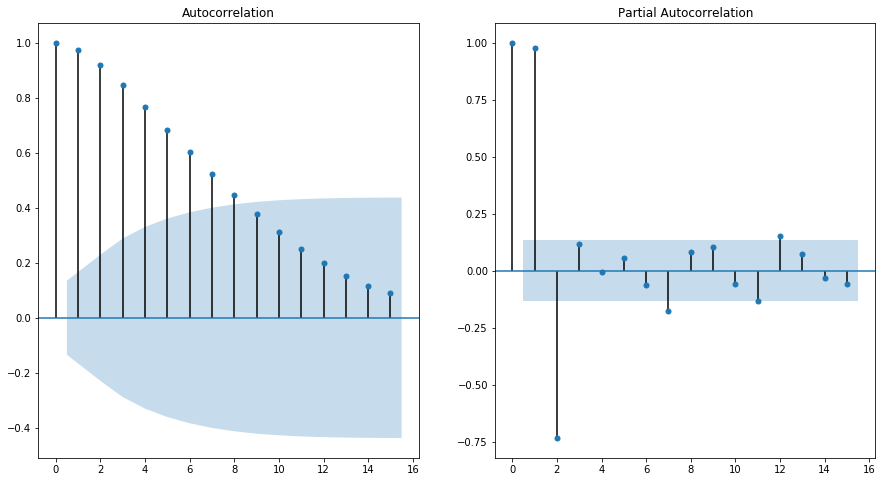

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(15,8))

fig = sm.graphics.tsa.plot_acf(data1.residus, lags=15, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(data1.residus, lags=15, ax=axes[1])

En observant l'autocorrélation et l'autocorrélation partielle, on peut remarquer qu'il est possible qu'il y ait une autocorrélation entre les erreurs jusqu'à l'ordre 2. 


## <span style='color:rgb(102, 51, 0)'> 11. Corriger l’autocorrélation des erreurs par la méthode vue en cours (à l'ordre 1)</span>

In [71]:
data1['unemp_c'] = data1.Unemp - results.params[0]*data1.Unemp.shift(periods=1, fill_value=0)
data1['INF_c'] = data1.INF - results.params[0]*data1.INF.shift(periods=1, fill_value=0)
Y = data1.unemp_c
X = data1.INF_c

model = sm.OLS(Y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                unemp_c   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.590
Date:                Sun, 12 Apr 2020   Prob (F-statistic):              0.109
Time:                        13:06:33   Log-Likelihood:                -143.47
No. Observations:                 212   AIC:                             290.9
Df Residuals:                     210   BIC:                             297.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1616      0.033      4.915      0.0

## Commentaire

Après correction, nous constatons que la variable INF_c n'est toujours pas significative même si la p_value associée s'est conssidérable améliorée. Nous tenterons de corriger l'autocorrélation jusqu'à l'ordre 2.

## <span style='color:rgb(102, 51, 0)'> 12. Tester la stabilité de la relation chômage-inflation sur deux sous-périodes de taille identique </span>

### Modèle général (Ensemble total de données)

In [72]:
model = sm.OLS(data1.unemp_c, sm.add_constant(data1.INF_c))
results = model.fit()

SCR_G = ((results.resid)**2).sum()

print(results.summary())
print(SCR_G)

                            OLS Regression Results                            
Dep. Variable:                unemp_c   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.590
Date:                Sun, 12 Apr 2020   Prob (F-statistic):              0.109
Time:                        13:06:34   Log-Likelihood:                -143.47
No. Observations:                 212   AIC:                             290.9
Df Residuals:                     210   BIC:                             297.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1616      0.033      4.915      0.0

### Modèle partiel 1 (1ère moitié de données)

In [73]:
model = sm.OLS(data1[0:105].unemp_c, sm.add_constant(data1[0:105].INF_c))
results = model.fit()

SCR_P1 = ((results.resid)**2).sum()

print(results.summary())
print(SCR_P1)

                            OLS Regression Results                            
Dep. Variable:                unemp_c   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     4.181
Date:                Sun, 12 Apr 2020   Prob (F-statistic):             0.0434
Time:                        13:06:35   Log-Likelihood:                -95.857
No. Observations:                 105   AIC:                             195.7
Df Residuals:                     103   BIC:                             201.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1976      0.060      3.320      0.0

### Modèle partiel 2 (2ème moitié de données)

In [74]:
model = sm.OLS(data1[106:].unemp_c, sm.add_constant(data1[106:].INF_c))
results = model.fit()

SCR_P2 = ((results.resid)**2).sum()

print(results.summary())
print(SCR_P2)

                            OLS Regression Results                            
Dep. Variable:                unemp_c   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                 0.0009031
Date:                Sun, 12 Apr 2020   Prob (F-statistic):              0.976
Time:                        13:06:35   Log-Likelihood:                -17.979
No. Observations:                 106   AIC:                             39.96
Df Residuals:                     104   BIC:                             45.29
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1284      0.028      4.564      0.0

### Test de CHOW

$\large H_0 :$ Pas de changements structurels importants

La statistique du test de Chow est donnée par:

CHOW_F_static :  $\Large \frac { \frac{SCR_{G} - (SCR_{P1} + SCR_{P2})}{2} }{ \frac{(SCR_{P1} + SCR_{P2})}{210 - 2*2} } $

Application numérique: $\Large \frac { \frac{48.046 - (38.165 + 8.712)}{2} }{ \frac{38.165 + 8.712}{210 - 2*2} } = \frac{1.169}{0.227} = 2.0309 $

In [75]:
((SCR_G - (SCR_P1 + SCR_P2))/2)/((SCR_P1 + SCR_P2)/206)

2.5672957972806

In [76]:
F = ((SCR_G - (SCR_P1 + SCR_P2))/2)/((SCR_P1 + SCR_P2)/206)
k = 2
n = 210
p = n-2*k
print('La p valeur associée à cette statistique est:.{}'.format(f.sf(F,k, p)))

La p valeur associée à cette statistique est:.0.0791965511486497


### Commentaire:

On rejette l'hypothèse H0 d'absence de changements de structure et on conclut qu'il y a bien un changement de structure entre les deux sous périodes de taille identique lorsqu'on prend en compte les données corrigées de l'autocorrélation d'ordre 2.

## <span style='color:rgb(102, 51, 0)'> 13. Faites les tests de changement de structure de Chow et détecter le point de rupture </span>

Nous allons appliquer le test de Chow en considérant une fenêtre d'application de 30 données. Nous utiliserons les valeurs corrigées de l'autocorrélation des erreurs.

In [77]:
F_statistic_Chow = []
p_valeur = []
date = []

for i in range(30, (len(data1.index)-30)):
    # Modèle non-contraint
    Y = data1.unemp_c
    X = data1.INF_c
    
    model = sm.OLS(Y, sm.add_constant(X))
    results = model.fit()
    SCR_G = ((results.resid)**2).sum()
    
    # Modèle contraint 1ère partie
    Y = data1.unemp_c[:i]
    X = data1.INF_c[:i]
    
    model = sm.OLS(Y, sm.add_constant(X))
    results = model.fit()
    SCR_P1 = ((results.resid)**2).sum()
    
    # Modèle contraint 2ème partie
    Y = data1.unemp_c[i:]
    X = data1.INF_c[i:]
    
    model = sm.OLS(Y, sm.add_constant(X))
    results = model.fit()
    SCR_P2 = ((results.resid)**2).sum()
    
    # F_statistics
    F = ((SCR_G -(SCR_P1 + SCR_P2))/2)/((SCR_P1 + SCR_P2)/(len(data1.unemp_c[:i]) + len(data1.unemp_c[i:])-2*2))
    F_statistic_Chow.append(F)
    # pvaleur
    pval = f.sf(F, 2, len(data1.unemp_c[:i]) + len(data1.unemp_c[i:])-2*2)
    p_valeur.append(pval)
    date.append(i)

## Détection des périodes de rupture

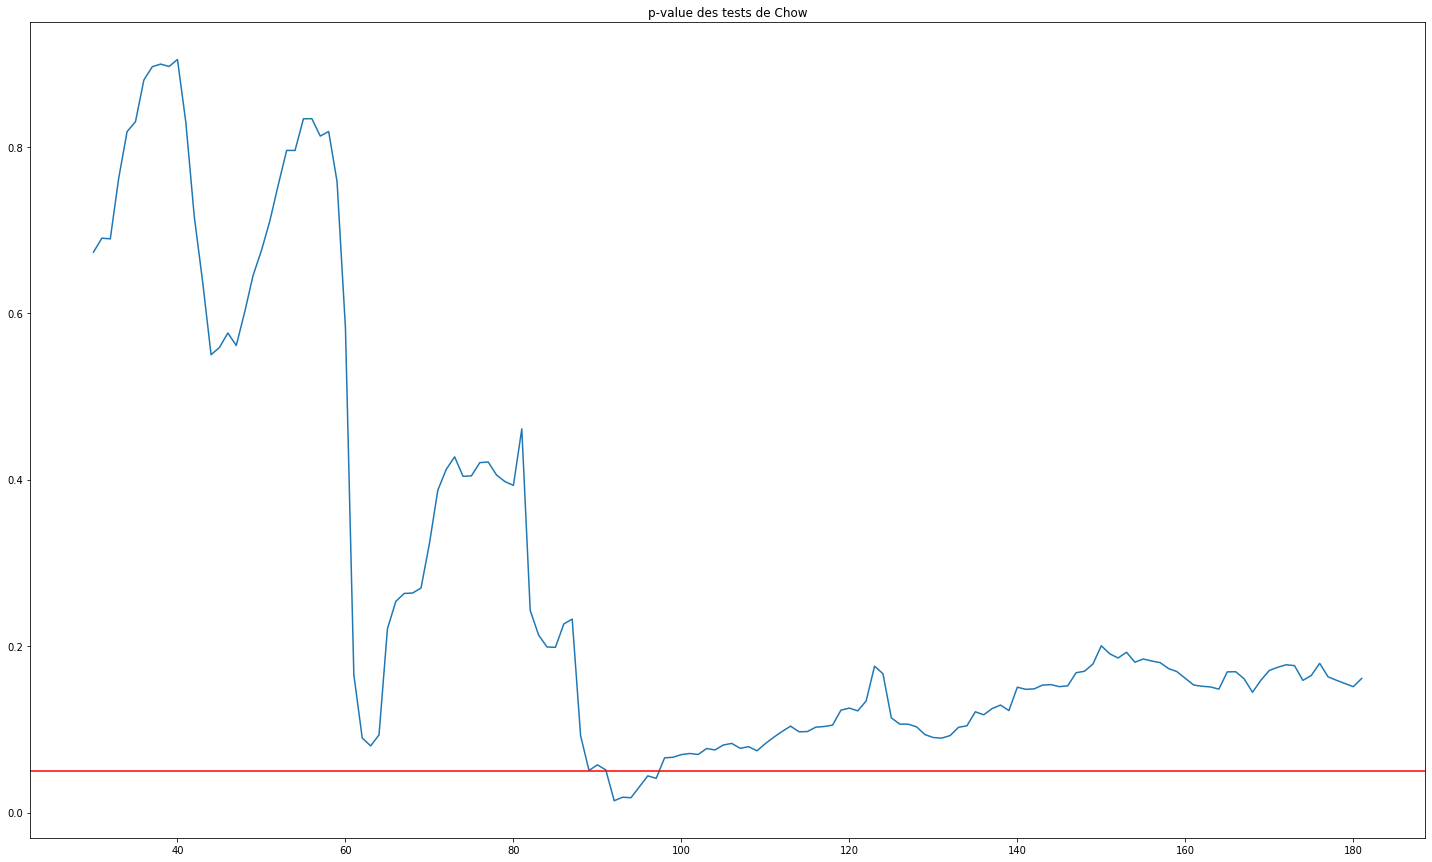

In [78]:
plt.figure(figsize=(25,15))
plt.plot(data1.index[30 : len(data1.index)-30], p_valeur)
plt.axhline(0.05, color='red')
plt.title("p-value des tests de Chow")
plt.show()

In [79]:
for date, p in enumerate(p_valeur):
    if p < 0.05:
        print(date + 30, p)

92 0.014210490051604869
93 0.018420147819224453
94 0.01784297547270407
95 0.030984900885447544
96 0.04409730649957328
97 0.04109761430360221


In [80]:
data1[92:98]

,index,DATE,FFR,Tbill,Tb1yr,r5,r10,PPINSA,Finished,CPI,...,RGDP,Potent,Deflator,Curr,CPI_lag,diff_CPI,INF,residus,unemp_c,INF_c
92,92,1983Q1,8.65,8.11,8.86,10.12,10.56,100.37,101.03,98.00,...,5938.9,6427.4,56.929,153.847,97.93,0.07,0.071480,4.309090,-0.083924,-0.229580
93,93,1983Q2,8.80,8.40,9.18,10.23,10.54,100.73,101.37,99.13,...,6072.4,6472.6,57.345,158.741,98.00,1.13,1.153061,4.044023,-0.029999,1.083029
94,94,1983Q3,9.46,9.14,10.30,11.42,11.63,101.70,101.90,100.10,...,6192.2,6518.3,57.929,162.801,99.13,0.97,0.978513,3.288068,-0.554859,-0.151198
95,95,1983Q4,9.43,8.80,9.95,11.41,11.69,102.20,102.17,101.10,...,6320.2,6564.9,58.355,167.248,100.10,1.00,0.999001,2.447593,-0.650250,0.040304
96,96,1984Q1,9.69,9.17,10.18,11.64,11.94,103.33,103.40,102.53,...,6442.8,6613.5,59.096,168.190,101.10,1.43,1.414441,1.777965,-0.487260,0.435671
97,97,1984Q2,10.56,9.80,11.55,13.01,13.20,104.03,103.83,103.50,...,6554.0,6664.6,59.602,172.241,102.53,0.97,0.946065,1.348820,-0.280626,-0.439733


### Commentaire
On conlut que le point de rupture correspond au premier trimestre de l'année 1983 soit 1983Q1 car c'est à ce point qu'on observe le premier et sévère point de rupture.

## <span style='color:rgb(102, 51, 0)'> 14. Estimer la courbe de Philips en supprimant l'inflation courante des variables explicatives mais en ajoutant les délais d’ordre 1, 2, 3 et 4 de l’inflation et du chômage. Faire le test de Granger de non causalité de l’inflation sur le chômage. Donnez la p-valeur. </span>

Nous n'utiliserons pas les valeurs corrigées de l'autocorrélation des erreurs car la correction avait été faite sur les valeurs des variables à l'instant t. Cependant, pour cette question, nous ne travaillons que sur des valeurs retardées.

In [81]:
data1['X1'] = data1.Unemp.shift(periods=1, fill_value=0)
data1['X2'] = data1['X1'].shift(periods=1, fill_value=0)
data1['X3'] = data1['X2'].shift(periods=1, fill_value=0)
data1['X4'] = data1['X3'].shift(periods=1, fill_value=0)

data1['X5'] = data1.INF.shift(periods=1, fill_value=0)
data1['X6'] = data1['X5'].shift(periods=1, fill_value=0)
data1['X7'] = data1['X6'].shift(periods=1, fill_value=0)
data1['X8'] = data1['X7'].shift(periods=1, fill_value=0)

In [82]:
data11 = data1[5:]
cols = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
# Modèle non-contraint
Y = data11.Unemp
X = data11[cols]
    
model = sm.OLS(Y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Unemp   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1145.
Date:                Sun, 12 Apr 2020   Prob (F-statistic):          2.80e-161
Time:                        13:06:41   Log-Likelihood:                 4.6497
No. Observations:                 207   AIC:                             8.701
Df Residuals:                     198   BIC:                             38.70
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1457      0.072      2.014      0.0

### Commentaire:

Les variables qui représentent le chômage retardées d'une période et de deux périodes ainsi que l'inflation retardée de trois périodes sont les seules variables explicatives significatives du chômage courant.  

### Test de causalité de Granger

Le test de causalité de Granger est un test qui permet de décider sur le sens de causalité entre deux séries. Si nous disposons d'une serie $\large y_{t}$ et une autre série $\large x_{t}$, telle que :

$\large y_{t} = \beta_{0} + \beta_{1} y_{t-1} + \beta_{2} y_{t-2} + ... + \beta_{p} y_{t-p} + \alpha_{1} x_{t-1} + \alpha_{2} x_{t-2} + ... + \alpha_{q} x_{t-q} + \epsilon_{t}$

On dira que $\large x_{t}$ cause $\large y_{t}$ si les valeurs $\large \alpha_{1}, \alpha_{2} ... \alpha_{q} $ sont toutes significatives globalement. Autrement dit, $\large x_{t}$ cause $\large y_{t}$ si l'hypothèse $ \large H_{0}$ ci-dessous est rejetée contre l'hypothèse alternative en appliquant un test de Fisher.

$ \large H_{0}: \alpha_{1} = \alpha_{2} = ... = \alpha_{q} = 0$

### Dans ce cas d'étude, nous avons:

$\large unemp_{t} = \beta_{0} + \beta_{1} unemp_{t-1} + \beta_{2} unemp_{t-2} + \beta_{3} unemp_{t-3} + \beta_{4} unemp_{t-4} + \alpha_{1} INF_{t-1} + \alpha_{2} INF_{t-2} + \alpha_{3} INF_{t-3} + \alpha_{4} INF_{t-4} + \epsilon_{t}$

Si un test de Fisher nous amène à rejeter l'hypothèse $ \large H_{0}$ suivante: 

$ \large H_{0}: \alpha_{1} = \alpha_{2} = \alpha_{3} = \alpha_{3} = 0$

alors on pourra conclure que INF cause unemp

### Modèle non contraint

In [83]:
data11 = data1[5:]
cols = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
# Modèle non-contraint
Y = data11.Unemp
X = data11[cols]
    
model = sm.OLS(Y, sm.add_constant(X))
results = model.fit()
print(results.summary())
SCR_nc = ((results.resid)**2).sum()

                            OLS Regression Results                            
Dep. Variable:                  Unemp   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1145.
Date:                Sun, 12 Apr 2020   Prob (F-statistic):          2.80e-161
Time:                        13:06:43   Log-Likelihood:                 4.6497
No. Observations:                 207   AIC:                             8.701
Df Residuals:                     198   BIC:                             38.70
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1457      0.072      2.014      0.0

### Modèle contraint

In [84]:
cols = ['X1', 'X2', 'X3', 'X4']
# Modèle non-contraint
Y = data11.Unemp
X = data11[cols]
    
model = sm.OLS(Y, sm.add_constant(X))
results = model.fit()
print(results.summary())
SCR_c = ((results.resid)**2).sum()

                            OLS Regression Results                            
Dep. Variable:                  Unemp   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     2165.
Date:                Sun, 12 Apr 2020   Prob (F-statistic):          1.36e-164
Time:                        13:06:44   Log-Likelihood:                -2.9991
No. Observations:                 207   AIC:                             16.00
Df Residuals:                     202   BIC:                             32.66
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2157      0.071      3.036      0.0

In [85]:
n = 207
k = 9
F=((SCR_c - SCR_nc)/1)/(SCR_nc/(n-k))
print('La statistique du test de Fisher joint est:{}'.format(F))
pval = f.sf(F,1,n-k)
print('La p valeur associée à cette statistique est:{}'.format(pval))

La statistique du test de Fisher joint est:15.186796792821255
La p valeur associée à cette statistique est:0.0001332064314566492


### Autre méthode du test de causalité de granger

In [86]:
from statsmodels.tsa.stattools import grangercausalitytests as granger
granger(data1[['Unemp', 'INF']], 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.8457  , p=0.0033  , df_denom=208, df_num=1
ssr based chi2 test:   chi2=8.9733  , p=0.0027  , df=1
likelihood ratio test: chi2=8.7878  , p=0.0030  , df=1
parameter F test:         F=8.8457  , p=0.0033  , df_denom=208, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1689  , p=0.0168  , df_denom=205, df_num=2
ssr based chi2 test:   chi2=8.5411  , p=0.0140  , df=2
likelihood ratio test: chi2=8.3720  , p=0.0152  , df=2
parameter F test:         F=4.1689  , p=0.0168  , df_denom=205, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2157  , p=0.0064  , df_denom=202, df_num=3
ssr based chi2 test:   chi2=13.0855 , p=0.0045  , df=3
likelihood ratio test: chi2=12.6922 , p=0.0054  , df=3
parameter F test:         F=4.2157  , p=0.0064  , df_denom=202, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7724  , p=0.0056  

{1: ({'ssr_ftest': (8.845744681156024, 0.003284840194776479, 208.0, 1),
   'ssr_chi2test': (8.973327537134235, 0.0027394922463425467, 1),
   'lrtest': (8.787763249395482, 0.003032578524142799, 1),
   'params_ftest': (8.845744681155997, 0.0032848401947765246, 208.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.168859725152837, 0.0168010650867205, 205.0, 2),
   'ssr_chi2test': (8.54107846128874, 0.01397424577977313, 2),
   'lrtest': (8.371958334422516, 0.015207308151878287, 2),
   'params_ftest': (4.168859725152691, 0.016801065086723074, 205.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (4.215734575316732, 0.006431367127944339, 202.0, 3),
   'ssr_chi2test': (13.085473161997975, 0.004455363906951731, 3),
   'lrtest': (12.692166640813184, 0.005351889994724742, 3),
   'params_ftest': (4.215734575316746, 0.0064313671279441756, 202.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          

### Commentaire:

Les deux méthodes employées ci-dessus montrent bien que c'est l'inflation qui crée le chômage car dans chacune de ces méthodes, on rejette l'hypothèse nulle $\large H_{0}$. En se basant sur ce test et sur la théorie économique on conclut donc que l'inflation peut être à l'origine du chômage (cf. Courbe de Phillips).

## <span style='color:rgb(102, 51, 0)'> 15- Représentez graphiquement les délais distribués et commentez. Calculer l’impact à long de terme de l’inflation sur le chômage. </span>

Nous allons définir le délai distribué comme l'impact de chacune des variables retardée de l'inflation sur le chômage. Partant de cette définition, la représentation des délais distribués sera la réprésentation des coefficients associés aux variables retardées $\large (INF_{t-1}, INF_{t-2}, INF_{t-3}, INF_{t-4})$

In [87]:
data11 = data1[5:]
cols = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
# Modèle non-contraint
Y = data11.Unemp
X = data11[cols]
    
model = sm.OLS(Y, sm.add_constant(X))
results = model.fit()
print(results.params[5:])

X5    0.031105
X6   -0.023578
X7    0.068949
X8    0.016329
dtype: float64


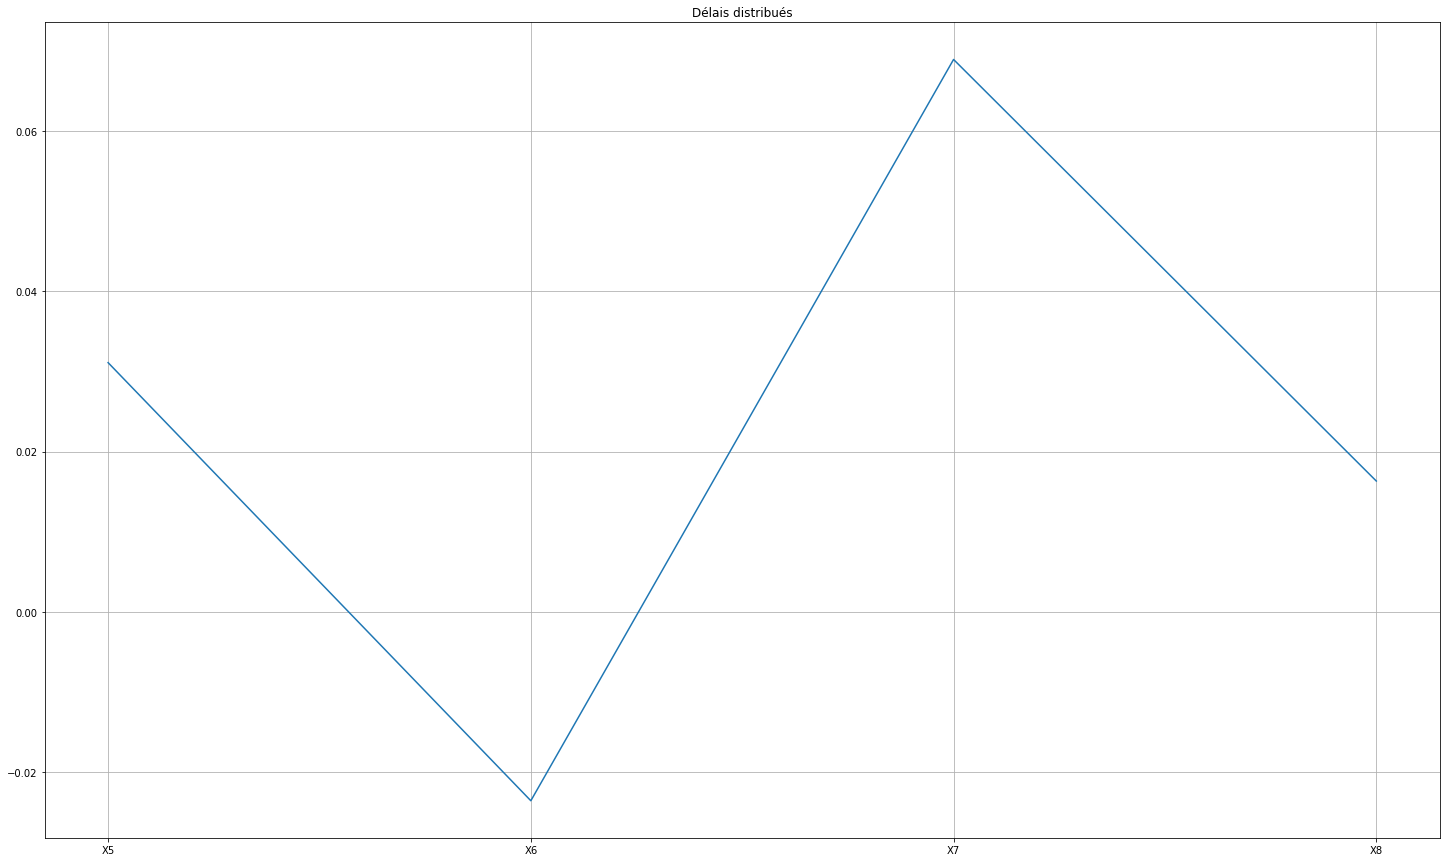

In [88]:
plt.figure(figsize=(25, 15))
plt.plot(results.params[5:])
plt.grid(True)
plt.title("Délais distribués");

### Commentaire

Les delais ne s'aménuisent pas au fur et à mesure que le temps évolue car la courbe si dessus ne temps pas à converger vers la valeur zéro.

### Pour obtenir l'effet de long terme, nous allons estimer un modèle à correction d'erreur.

Ce modèle est donné par l'équation suivante:

$\large (Unemp_{t}-Unemp_{t-1}) = \alpha_{0} + \alpha_{1}(INF_{t} - INF_{t-1}) + \alpha_{2} Unemp_{t-1} + \alpha_{3} INF_{t-1} + \epsilon_{t} $

Où $\large \alpha_{1}$ représente l'effet de court terme et $\large (\alpha_{2} + \alpha_{3})$ est l'effet de long terme.


In [89]:
data1['Unemp_diff'] = data1.Unemp - data1.Unemp.shift(periods=1, fill_value=0)
data1['INF_diff'] = data1.INF - data1.INF.shift(periods=1, fill_value=0)
data1['Unemp_r'] = data1.Unemp.shift(periods=1, fill_value=0)
data1['INF_r'] = data1.INF.shift(periods=1, fill_value=0)

cols = ['INF_diff', 'Unemp_r', 'INF_r']

Y = data1.Unemp_diff
X = data1[cols]

model = sm.OLS(Y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Unemp_diff   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     5.678
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           0.000934
Time:                        13:06:47   Log-Likelihood:                -139.55
No. Observations:                 212   AIC:                             287.1
Df Residuals:                     208   BIC:                             300.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4501      0.129      3.486      0.0

In [90]:
print('Effet de court terme: {}'.format(results.params[1]))
print('Effet de long terme: {}'.format(results.params[2] + results.params[3]))

Effet de court terme: -0.09074988159257666
Effet de long terme: -0.04229616170250111


La realtion à court terme entre l'inflation et le chômage est décroissante. A court terme, l'effet est plus important qu'à long terme. Une hausse d'une unité d'inflation est à l'origine toute chose étant égale par ailleurs à une baisse du chômage de 9.07% d'unité. A long cet effet n'est que de 4.22% d'unité.